## ĐỒ ÁN NMKHDL 

- Trần Vương Thiên : 1712781
- Tống Sơn Tùng : 18120642

___
## I: Khám phá dữ liệu


In [3]:

import datetime, warnings, scipy 
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from matplotlib.patches import ConnectionPatch
from collections import OrderedDict
from matplotlib.gridspec import GridSpec
# from mpl_toolkits.basemap import Basemap
from sklearn import metrics, linear_model
from sklearn.preprocessing import PolynomialFeatures, StandardScaler
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.model_selection import train_test_split, cross_val_score, cross_val_predict
from scipy.optimize import curve_fit
plt.rcParams["patch.force_edgecolor"] = True
plt.style.use('fivethirtyeight')
mpl.rc('patch', edgecolor = 'dimgray', linewidth=1)
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "last_expr"
pd.options.display.max_columns = 50
%matplotlib inline
warnings.filterwarnings("ignore")

Đọc dữ liệu từ flight.csv, Đồng thời cho biết kích thước của tệp dữ liệu, thông tin kiểu dữ liệu, tỉ lệ giá trị thiếu của từng thuộc tính

In [4]:
df = pd.read_csv('flights.csv', low_memory=False)
print('Dataframe dimensions:', df.shape)
#____________________________________________________________
# gives some infos on columns types and number of null values
tab_info=pd.DataFrame(df.dtypes).T.rename(index={0:'column type'})
tab_info=tab_info.append(pd.DataFrame(df.isnull().sum()).T.rename(index={0:'null values (nb)'}))
tab_info=tab_info.append(pd.DataFrame(df.isnull().sum()/df.shape[0]*100)
                         .T.rename(index={0:'null values (%)'}))
tab_info

Dataframe dimensions: (1048575, 31)


,YEAR,MONTH,DAY,DAY_OF_WEEK,AIRLINE,FLIGHT_NUMBER,TAIL_NUMBER,ORIGIN_AIRPORT,DESTINATION_AIRPORT,SCHEDULED_DEPARTURE,DEPARTURE_TIME,DEPARTURE_DELAY,TAXI_OUT,WHEELS_OFF,SCHEDULED_TIME,ELAPSED_TIME,AIR_TIME,DISTANCE,WHEELS_ON,TAXI_IN,SCHEDULED_ARRIVAL,ARRIVAL_TIME,ARRIVAL_DELAY,DIVERTED,CANCELLED,CANCELLATION_REASON,AIR_SYSTEM_DELAY,SECURITY_DELAY,AIRLINE_DELAY,LATE_AIRCRAFT_DELAY,WEATHER_DELAY
column type,int64,int64,int64,int64,object,int64,object,object,object,int64,float64,float64,float64,float64,float64,float64,float64,int64,float64,float64,int64,float64,float64,int64,int64,object,float64,float64,float64,float64,float64
null values (nb),0,0,0,0,0,0,7750,0,0,0,39515,39515,40229,40229,2,43071,43071,0,41296,41296,0,41296,43071,0,0,1008048,820047,820047,820047,820047,820047
null values (%),0,0,0,0,0,0,0.739098,0,0,0,3.76845,3.76845,3.83654,3.83654,0.000190735,4.10757,4.10757,0,3.9383,3.9383,0,3.9383,4.10757,0,0,96.135,78.2059,78.2059,78.2059,78.2059,78.2059


Mỗi dòng trong file `flight.csv` tương ứng với một chuyến bay được mô tả theo 31 biến. 
Ý nghĩa của một số biến quan trọng:
- **YEAR, MONTH, DAY, DAY_OF_WEEK**: Thời điểm chuyến bay bắt đầu <br/>
- **AIRLINE**: Mã hãng hàng không<br/>
- **ORIGIN_AIRPORT** and **DESTINATION_AIRPORT**: Mã do IATA cấp cho mỗi sân bay <br/>
- **SCHEDULED_DEPARTURE** and **SCHEDULED_ARRIVAL** : Lịch trình cất cánh, hạ cánh <br/> 
- **DEPARTURE_TIME** and **ARRIVAL_TIME**: Thời gian cất cánh, hạ cánh thực tế <br/> 
- **DEPARTURE_DELAY** and **ARRIVAL_DELAY**: thời gian delay khi hạ cánh, cất cánh <br/> 
- **DISTANCE**: Khoảng cách tính theo mét giữa 2 sân bay của 1 chuyến bay  <br/>
Tệp `airport.csv`, cung cấp mô tả đầy đủ hơn về các sân bay:

In [5]:
airports = pd.read_csv("airports.csv")

Cho biết số lượng chuyến bay được ghi nhận trong năm 2019 của từng sân bay:

In [6]:
count_flights = df['ORIGIN_AIRPORT'].value_counts()
count_flights

ATL    66599
ORD    52961
DFW    50933
LAX    38473
DEN    38254
       ...  
UST       33
BGR       22
PPG       21
ADK       20
ITH        6
Name: ORIGIN_AIRPORT, Length: 315, dtype: int64

Với kích thước lớn của tập dữ liệu, em quyết định chỉ xem xét một tập hợp con của dữ liệu để giảm thời gian tính toán. Ta sẽ chỉ giữ những chuyến bay ở tháng 1

In [7]:
df = df[df['MONTH'] == 1]

___
## 1. Cleaning
___
### 1.1 Dates and times
- Trong khung dữ liệu ban đầu, ngày tháng được mã hóa theo 4 biến: 
**YEAR, MONTH, DAY** và **DAY_OF_WEEK**. Trên thực tế, python cung cấp định dạng **_ datetime _** thực sự thuận tiện để làm việc với ngày và giờ và do đó ta chuyển đổi ngày ở định dạng này:


In [8]:
df['DATE'] = pd.to_datetime(df[['YEAR','MONTH', 'DAY']])

- Trong biến SCHEDULED_DEPARTURE, giờ cất cánh được mã hóa dưới dạng float. Trong đó hai chữ số đầu tiên cho biết giờ và hai chữ số cuối cùng là phút. Định dạng này không thuận tiện và do đó ta chuyển đổi nó. Cuối cùng, ta hợp nhất giờ cất cánh với ngày bay. Để tiến hành các phép biến đổi này, ta định nghĩa một số hàm:

In [9]:
#_________________________________________________________
#convert 'HHMM' sang datetime.time
def format_hours(chaine):
    if pd.isnull(chaine):
        return np.nan
    else:
        if chaine == 2400: chaine = 0
        chaine = "{0:04d}".format(int(chaine))
        hours = datetime.time(int(chaine[0:2]), int(chaine[2:4]))
        return hours
#_____________________________________________________________________
# Ghép date và time thành datetime.datetime
def combine_date_hours(x):
    if pd.isnull(x[0]) or pd.isnull(x[1]):
        return np.nan
    else:
        return datetime.datetime.combine(x[0],x[1])
#_______________________________________________________________________________
# Ghép 2 cột thành 1 cột với định dạng datetime
def create_flight_time(df, col):    
    liste = []
    for index, cols in df[['DATE', col]].iterrows():    
        if pd.isnull(cols[1]):
            liste.append(np.nan)
        elif float(cols[1]) == 2400:
            cols[0] += datetime.timedelta(days=1)
            cols[1] = datetime.time(0,0)
            liste.append(combine_date_hours(cols))
        else:
            cols[1] = format_hours(cols[1])
            liste.append(combine_date_hours(cols))
    return pd.Series(liste)

Giờ ta gọi các hàm này để sửa đổi lại dữ liệu các biến:

In [10]:
df['SCHEDULED_DEPARTURE'] = create_flight_time(df, 'SCHEDULED_DEPARTURE')
df['DEPARTURE_TIME'] = df['DEPARTURE_TIME'].apply(format_hours)
df['SCHEDULED_ARRIVAL'] = df['SCHEDULED_ARRIVAL'].apply(format_hours)
df['ARRIVAL_TIME'] = df['ARRIVAL_TIME'].apply(format_hours)
#__________________________________________________________________________
df.loc[:5, ['SCHEDULED_DEPARTURE', 'SCHEDULED_ARRIVAL', 'DEPARTURE_TIME',
             'ARRIVAL_TIME', 'DEPARTURE_DELAY', 'ARRIVAL_DELAY']]

,SCHEDULED_DEPARTURE,SCHEDULED_ARRIVAL,DEPARTURE_TIME,ARRIVAL_TIME,DEPARTURE_DELAY,ARRIVAL_DELAY
0,2019-01-01 00:05:00,04:30:00,23:54:00,04:08:00,-11.0,-22.0
1,2019-01-01 00:10:00,07:50:00,00:02:00,07:41:00,-8.0,-9.0
2,2019-01-01 00:20:00,08:06:00,00:18:00,08:11:00,-2.0,5.0
3,2019-01-01 00:20:00,08:05:00,00:15:00,07:56:00,-5.0,-9.0
4,2019-01-01 00:25:00,03:20:00,00:24:00,02:59:00,-1.0,-21.0
5,2019-01-01 00:25:00,06:02:00,00:20:00,06:10:00,-5.0,8.0


Lưu ý rằng trên thực tế, nội dung của các biến **DEPARTURE_TIME** và **ARRIVAL_TIME** có thể gây hiểu lầm một chút vì chúng không chứa ngày tháng. Ví dụ, trong mục nhập đầu tiên của khung dữ liệu, chuyến khởi hành dự kiến ​​là lúc 0h05 ngày 1 tháng 1. Biến **DEPARTURE_TIME** cho biết 23h54 và do đó chúng ta không biết liệu chuyến bay có khởi hành trước thời gian hay không hay có sự chậm trễ lớn hay không. Do đó, các biến **DEPARTURE_DELAY** và **ARRIVAL_DELAY** tỏ ra hữu ích hơn vì chúng trực tiếp cung cấp độ trễ trong vài phút. Vì vậy, trong phần tiếp theo, ta sẽ không sử dụng các biến **DEPARTURE_TIME** và **ARRIVAL_TIME**.


### 1.2 Filling factor

Dọn dẹp tập dữ liệu bằng cách bỏ các biến ta sẽ không sử dụng và sắp xếp lại các cột để dễ đọc:

In [11]:
list_variables_remove = ['TAXI_OUT', 'TAXI_IN', 'WHEELS_ON', 'WHEELS_OFF', 'YEAR', 
                       'MONTH','DAY','DAY_OF_WEEK','DATE', 'AIR_SYSTEM_DELAY',
                       'SECURITY_DELAY', 'AIRLINE_DELAY', 'LATE_AIRCRAFT_DELAY',
                       'WEATHER_DELAY', 'DIVERTED', 'CANCELLED', 'CANCELLATION_REASON',
                       'FLIGHT_NUMBER', 'TAIL_NUMBER', 'AIR_TIME']
df.drop(list_variables_remove, axis = 1, inplace = True)
df = df[['AIRLINE', 'ORIGIN_AIRPORT', 'DESTINATION_AIRPORT',
        'SCHEDULED_DEPARTURE', 'DEPARTURE_TIME', 'DEPARTURE_DELAY',
        'SCHEDULED_ARRIVAL', 'ARRIVAL_TIME', 'ARRIVAL_DELAY',
        'SCHEDULED_TIME', 'ELAPSED_TIME']]
df[:50]

,AIRLINE,ORIGIN_AIRPORT,DESTINATION_AIRPORT,SCHEDULED_DEPARTURE,DEPARTURE_TIME,DEPARTURE_DELAY,SCHEDULED_ARRIVAL,ARRIVAL_TIME,ARRIVAL_DELAY,SCHEDULED_TIME,ELAPSED_TIME
0,AS,ANC,SEA,2019-01-01 00:05:00,23:54:00,-11.0,04:30:00,04:08:00,-22.0,205.0,194.0
1,AA,LAX,PBI,2019-01-01 00:10:00,00:02:00,-8.0,07:50:00,07:41:00,-9.0,280.0,279.0
2,US,SFO,CLT,2019-01-01 00:20:00,00:18:00,-2.0,08:06:00,08:11:00,5.0,286.0,293.0
3,AA,LAX,MIA,2019-01-01 00:20:00,00:15:00,-5.0,08:05:00,07:56:00,-9.0,285.0,281.0
4,AS,SEA,ANC,2019-01-01 00:25:00,00:24:00,-1.0,03:20:00,02:59:00,-21.0,235.0,215.0
5,DL,SFO,MSP,2019-01-01 00:25:00,00:20:00,-5.0,06:02:00,06:10:00,8.0,217.0,230.0
6,NK,LAS,MSP,2019-01-01 00:25:00,00:19:00,-6.0,05:26:00,05:09:00,-17.0,181.0,170.0
7,US,LAX,CLT,2019-01-01 00:30:00,00:44:00,14.0,08:03:00,07:53:00,-10.0,273.0,249.0
8,AA,SFO,DFW,2019-01-01 00:30:00,00:19:00,-11.0,05:45:00,05:32:00,-13.0,195.0,193.0
9,DL,LAS,ATL,2019-01-01 00:30:00,00:33:00,3.0,07:11:00,06:56:00,-15.0,221.0,203.0


Ở giai đoạn này, ta kiểm tra mức độ hoàn chỉnh của tập dữ liệu:

In [12]:
missing_df = df.isnull().sum(axis=0).reset_index()
missing_df.columns = ['variable', 'missing values']
missing_df['filling factor (%)']=(df.shape[0]-missing_df['missing values'])/df.shape[0]*100
missing_df.sort_values('filling factor (%)').reset_index(drop = True)

,variable,missing values,filling factor (%)
0,ARRIVAL_DELAY,12955,97.243429
1,ELAPSED_TIME,12955,97.243429
2,ARRIVAL_TIME,12271,97.388971
3,DEPARTURE_TIME,11657,97.519618
4,DEPARTURE_DELAY,11657,97.519618
5,AIRLINE,0,100.000000
6,ORIGIN_AIRPORT,0,100.000000
7,DESTINATION_AIRPORT,0,100.000000
8,SCHEDULED_DEPARTURE,0,100.000000
9,SCHEDULED_ARRIVAL,0,100.000000


- Ta thấy hệ số lấp đầy các biến khá tốt (> 97%). Ta sẽ chỉ xóa các mục nhập chứa các giá trị bị thiếu.

In [13]:
df.dropna(inplace = True)

___
## 2. Comparing airlines


- Như đã nói trước đó, biến **AIRLINE** chứa các hãng hàng không. Tên đầy đủ của chúng có thể được truy xuất từ ​​tệp `airlines.csv`.

In [14]:
airlines_names = pd.read_csv('airlines.csv')
airlines_names

,IATA_CODE,AIRLINE
0,UA,United Air Lines Inc.
1,AA,American Airlines Inc.
2,US,US Airways Inc.
3,F9,Frontier Airlines Inc.
4,B6,JetBlue Airways
5,OO,Skywest Airlines Inc.
6,AS,Alaska Airlines Inc.
7,NK,Spirit Air Lines
8,WN,Southwest Airlines Co.
9,DL,Delta Air Lines Inc.


Để sau có thể sử dụng, ta đưa nội dung của chúng vào một từ điển:

In [15]:
abbr_companies = airlines_names.set_index('IATA_CODE')['AIRLINE'].to_dict()

___
### 2.1 Các hãng hàng không

- Bước đầu tiên, ta xem tất cả các chuyến bay từ tất cả các hãng. Ở đây, mục đích là để phân loại các hãng hàng không theo độ trễ của họ và vì mục đích đó, ta tính toán một vài thông số thống kê cơ bản:

In [16]:
#__________________________________________________________________
# hàm trích xuất các tham số thống kê từ một đối tượng theo nhóm:
def get_stats(group):
    return {'min': group.min(), 'max': group.max(),
            'count': group.count(), 'mean': group.mean()}
#_______________________________________________________________
# Tạo dataframe với thông tin của mỗi hãng hàng không:
global_stats = df['DEPARTURE_DELAY'].groupby(df['AIRLINE']).apply(get_stats).unstack()
global_stats = global_stats.sort_values('count')
global_stats

,min,max,count,mean
AIRLINE,,,,
VX,-20.0,397.0,4647.0,6.896277
HA,-26.0,1003.0,6408.0,1.311954
F9,-32.0,696.0,6735.0,17.910765
NK,-28.0,557.0,8632.0,13.073100
AS,-47.0,444.0,13151.0,3.072086
B6,-27.0,500.0,20482.0,9.988331
MQ,-29.0,780.0,27568.0,15.995865
US,-26.0,638.0,32478.0,5.175011
UA,-40.0,886.0,37363.0,13.885555


Để dễ hình dung, ta sẽ xây dựng một số mô hình:

findfont: Font family ['normal'] not found. Falling back to DejaVu Sans.
findfont: Font family ['normal'] not found. Falling back to DejaVu Sans.
findfont: Font family ['normal'] not found. Falling back to DejaVu Sans.
findfont: Font family ['normal'] not found. Falling back to DejaVu Sans.


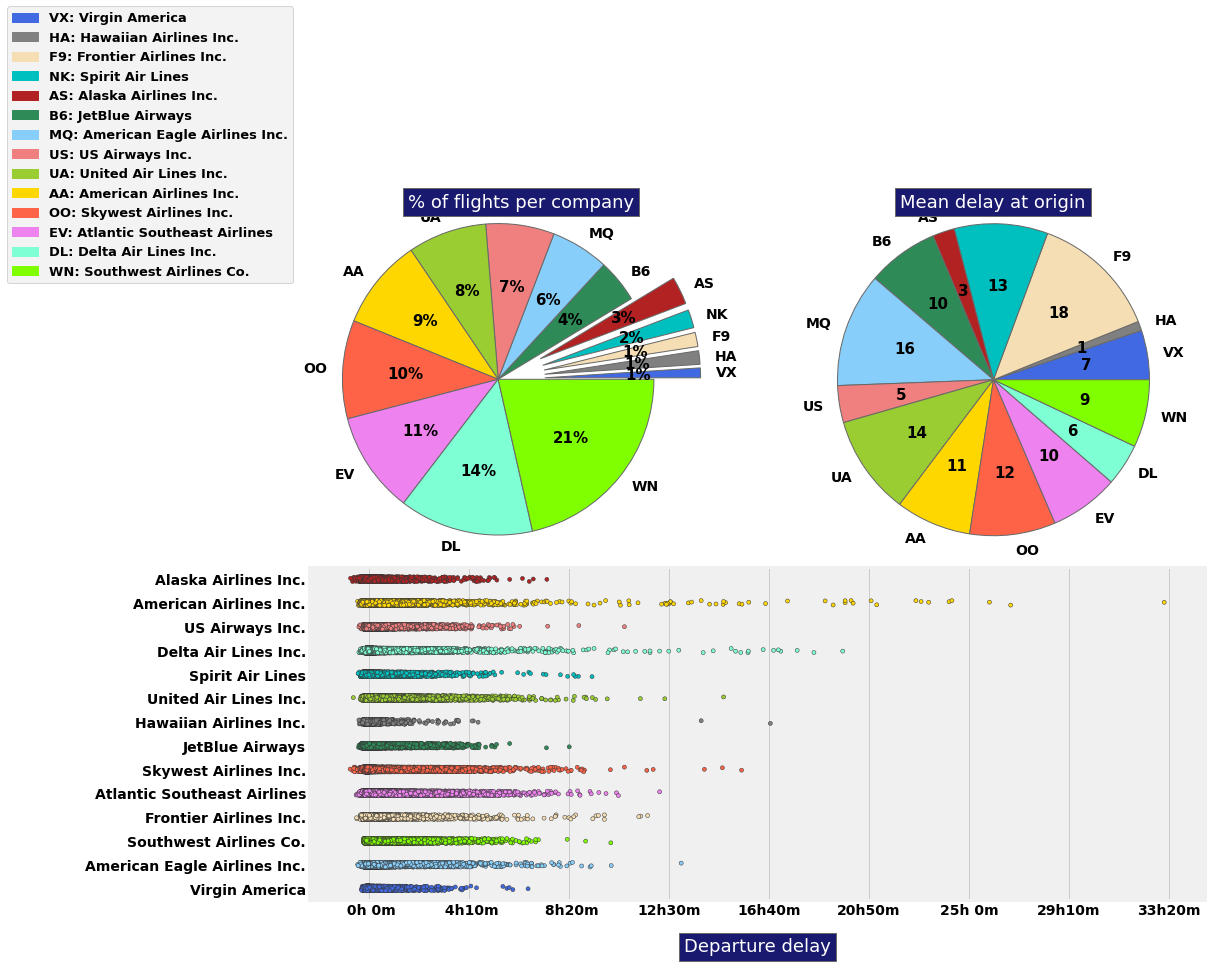

In [17]:
font = {'family' : 'normal', 'weight' : 'bold', 'size'   : 15}
mpl.rc('font', **font)
import matplotlib.patches as mpatches
#__________________________________________________________________
# extract a subset of columns and redefine the airlines labeling 
df2 = df.loc[:, ['AIRLINE', 'DEPARTURE_DELAY']]
df2['AIRLINE'] = df2['AIRLINE'].replace(abbr_companies)
#________________________________________________________________________
colors = ['royalblue', 'grey', 'wheat', 'c', 'firebrick', 'seagreen', 'lightskyblue',
          'lightcoral', 'yellowgreen', 'gold', 'tomato', 'violet', 'aquamarine', 'chartreuse']
#___________________________________
fig = plt.figure(1, figsize=(16,15))
gs=GridSpec(2,2)             
ax1=fig.add_subplot(gs[0,0]) 
ax2=fig.add_subplot(gs[0,1]) 
ax3=fig.add_subplot(gs[1,:]) 
#------------------------------
# Pie chart nº1: nb of flights
#------------------------------
labels = [s for s in  global_stats.index]
sizes  = global_stats['count'].values
explode = [0.3 if sizes[i] < 20000 else 0.0 for i in range(len(abbr_companies))]
patches, texts, autotexts = ax1.pie(sizes, explode = explode,
                                labels=labels, colors = colors,  autopct='%1.0f%%',
                                shadow=False, startangle=0)
for i in range(len(abbr_companies)): 
    texts[i].set_fontsize(14)
ax1.axis('equal')
ax1.set_title('% of flights per company', bbox={'facecolor':'midnightblue', 'pad':5},
              color = 'w',fontsize=18)
#_______________________________________________
# set the legend: abreviation -> airline name
comp_handler = []
for i in range(len(abbr_companies)):
    comp_handler.append(mpatches.Patch(color=colors[i],
            label = global_stats.index[i] + ': ' + abbr_companies[global_stats.index[i]]))
ax1.legend(handles=comp_handler, bbox_to_anchor=(0.2, 0.9), 
           fontsize = 13, bbox_transform=plt.gcf().transFigure)
#----------------------------------------
# Pie chart nº2: mean delay at departure
#----------------------------------------
sizes  = global_stats['mean'].values
sizes  = [max(s,0) for s in sizes]
explode = [0.0 if sizes[i] < 20000 else 0.01 for i in range(len(abbr_companies))]
patches, texts, autotexts = ax2.pie(sizes, explode = explode, labels = labels,
                                colors = colors, shadow=False, startangle=0,
                                autopct = lambda p :  '{:.0f}'.format(p * sum(sizes) / 100))
for i in range(len(abbr_companies)): 
    texts[i].set_fontsize(14)
ax2.axis('equal')
ax2.set_title('Mean delay at origin', bbox={'facecolor':'midnightblue', 'pad':5},
              color='w', fontsize=18)
#------------------------------------------------------
# striplot with all the values reported for the delays
#___________________________________________________________________
# redefine the colors for correspondance with the pie charts
colors = ['firebrick', 'gold', 'lightcoral', 'aquamarine', 'c', 'yellowgreen', 'grey',
          'seagreen', 'tomato', 'violet', 'wheat', 'chartreuse', 'lightskyblue', 'royalblue']
#___________________________________________________________________
ax3 = sns.stripplot(y="AIRLINE", x="DEPARTURE_DELAY", size = 4, palette = colors,
                    data=df2, linewidth = 0.5,  jitter=True)
plt.setp(ax3.get_xticklabels(), fontsize=14)
plt.setp(ax3.get_yticklabels(), fontsize=14)
ax3.set_xticklabels(['{:2.0f}h{:2.0f}m'.format(*[int(y) for y in divmod(x,60)])
                         for x in ax3.get_xticks()])
plt.xlabel('Departure delay', fontsize=18, bbox={'facecolor':'midnightblue', 'pad':5},
           color='w', labelpad=20)
ax3.yaxis.label.set_visible(False)
#________________________
plt.tight_layout(w_pad=3) 

Ta thấy rằng mặc dù tất cả các trường hợp chậm trễ khoảng 10 phút, giá trị thấp này là hệ quả của thực tế là phần lớn các chuyến bay cất cánh đúng giờ. Tuy nhiên, ta thấy rằng đôi khi, có thể phải đối mặt với độ trễ lớn, có thể lên đến vài chục giờ!
Thể hiện độ trễ có thể nhìn thấy trong hình tiếp theo:

findfont: Font family ['normal'] not found. Falling back to DejaVu Sans.
findfont: Font family ['normal'] not found. Falling back to DejaVu Sans.
findfont: Font family ['normal'] not found. Falling back to DejaVu Sans.


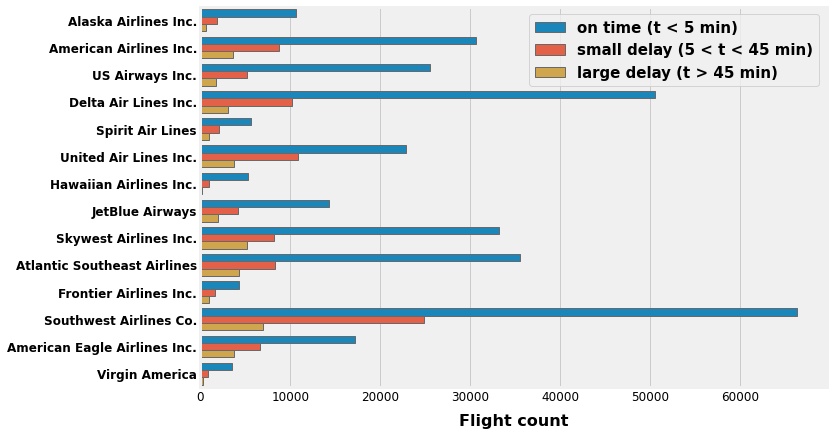

In [18]:
#_____________________________________________
# Function that define how delays are grouped
delay_type = lambda x:((0,1)[x > 5],2)[x > 45]
df['DELAY_LEVEL'] = df['DEPARTURE_DELAY'].apply(delay_type)
#____________________________________________________
fig = plt.figure(1, figsize=(10,7))
ax = sns.countplot(y="AIRLINE", hue='DELAY_LEVEL', data=df)
#____________________________________________________________________________________
# thay thế các chữ viết tắt bằng tên đầy đủ của các công ty và đặt nhãn
labels = [abbr_companies[item.get_text()] for item in ax.get_yticklabels()]
ax.set_yticklabels(labels)
plt.setp(ax.get_xticklabels(), fontsize=12, weight = 'normal', rotation = 0);
plt.setp(ax.get_yticklabels(), fontsize=12, weight = 'bold', rotation = 0);
ax.yaxis.label.set_visible(False)
plt.xlabel('Flight count', fontsize=16, weight = 'bold', labelpad=10)
#________________
# Set the legend
L = plt.legend()
L.get_texts()[0].set_text('on time (t < 5 min)')
L.get_texts()[1].set_text('small delay (5 < t < 45 min)')
L.get_texts()[2].set_text('large delay (t > 45 min)')
plt.show()

Con số này cho biết số lần trễ dưới 5 phút, trễ trong khoảng 5 <t <45 phút và cuối cùng là số lần trễ hơn 45 phút. Do đó, ta có thể nhận định rằng độ trễ độc lập với hãng hàng không, việc chậm trễ hơn 45 phút chỉ chiếm một vài phần trăm. Tuy nhiên, tỷ lệ chậm trễ trong ba nhóm này phụ thuộc vào hãng hàng không: như một ví dụ, trong trường hợp
*SkyWest Airlines*, các trường hợp chậm trễ hơn 45 phút chỉ thấp hơn 30% đối với các trường hợp chậm trễ trong khoảng 5 <t <45 phút. Mọi thứ tốt hơn cho *SoutWest Airlines* vì các chuyến bay chậm hơn 45 phút ít thường xuyên hơn 4 lần so với các chuyến bay trong khoảng 5 <t <45 phút.


### 2.2 Phân bố độ trễ
- Trong phần này, ta xem xét chi tiết hơn về việc phân bổ sự chậm trễ của mọi hãng hàng không:

___
## 3. Delays: take-off or landing ?

- Trong phần trước, tất cả các cuộc thảo luận đã được thực hiện về sự chậm trễ khởi hành. Tuy nhiên, những sự chậm trễ này hơi khác so với những sự chậm trễ được ghi nhận khi đến:

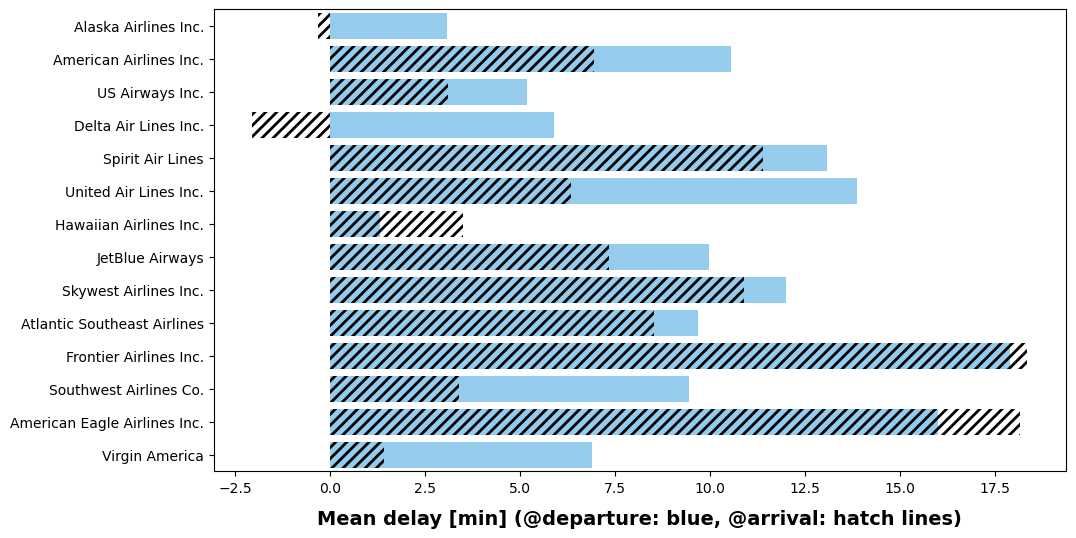

In [19]:
mpl.rcParams.update(mpl.rcParamsDefault)
mpl.rcParams['hatch.linewidth'] = 2.0  

fig = plt.figure(1, figsize=(11,6))
ax = sns.barplot(x="DEPARTURE_DELAY", y="AIRLINE", data=df, color="lightskyblue", ci=None)
ax = sns.barplot(x="ARRIVAL_DELAY", y="AIRLINE", data=df, color="r", hatch = '///',
                 alpha = 0.0, ci=None)
labels = [abbr_companies[item.get_text()] for item in ax.get_yticklabels()]
ax.set_yticklabels(labels)
ax.yaxis.label.set_visible(False)
plt.xlabel('Mean delay [min] (@departure: blue, @arrival: hatch lines)',
           fontsize=14, weight = 'bold', labelpad=10);

- Trên hình này, chúng ta có thể thấy rằng sự chậm trễ khi đến thường thấp hơn lúc khởi hành. Điều này cho thấy các hãng hàng không điều chỉnh tốc độ chuyến bay của họ để giảm sự chậm trễ khi đến. Trong phần tiếp theo, ta sẽ chỉ xem xét sự chậm trễ khi khởi hành.

___
## 4. Mối quan hệ giữa "ORIGIN_AIRPORT" và độ trễ

- Bây giờ ta sẽ cố gắng xác định xem có mối tương quan giữa độ trễ và sân bay xuất phát hay không.Số lượng sân bay được xem xét là:

In [20]:
print("Nb of airports: {}".format(len(df['ORIGIN_AIRPORT'].unique())))

Nb of airports: 312



### 4.1 Khu vực địa lý của các hãng hàng không
Ở đây, ta xem nhanh qua về số lượng sân bay đến của mỗi hãng hàng không:


In [21]:
origin_nb = dict()
for carrier in abbr_companies.keys():
    liste_origin_airport = df[df['AIRLINE'] == carrier]['ORIGIN_AIRPORT'].unique()
    origin_nb[carrier] = len(liste_origin_airport)

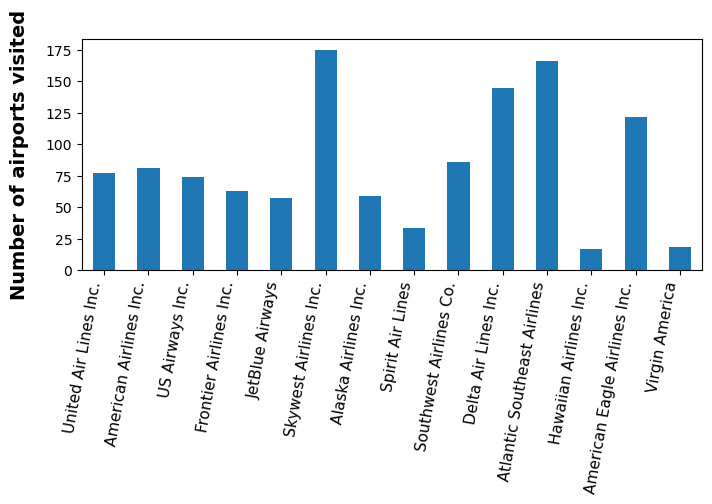

In [22]:
test_df = pd.DataFrame.from_dict(origin_nb, orient='index')
test_df.rename(columns = {0:'count'}, inplace = True)
ax = test_df.plot(kind='bar', figsize = (8,3))
labels = [abbr_companies[item.get_text()] for item in ax.get_xticklabels()]
ax.set_xticklabels(labels)
plt.ylabel('Number of airports visited', fontsize=14, weight = 'bold', labelpad=12)
plt.setp(ax.get_xticklabels(), fontsize=11, ha = 'right', rotation = 80)
ax.legend().set_visible(False)
plt.show()

In [23]:
temp = pd.read_csv('airports.csv')
identify_airport = temp.set_index('IATA_CODE')['CITY'].to_dict()
latitude_airport = temp.set_index('IATA_CODE')['LATITUDE'].to_dict()
longitude_airport = temp.set_index('IATA_CODE')['LONGITUDE'].to_dict()

___
### 4.2 Cách yếu tố "ORIGIN_AIRPORT" tác động đến độ trễ

- Trong phần này, Ta sẽ xem xét các biến thể của sự chậm trễ đối với sân bay xuất phát và đối với mọi hãng hàng không. Do đó, bước đầu tiên bao gồm xác định độ trễ trung bình cho mỗi sân bay:

In [24]:
airport_mean_delays = pd.DataFrame(pd.Series(df['ORIGIN_AIRPORT'].unique()))
airport_mean_delays.set_index(0, drop = True, inplace = True)

for carrier in abbr_companies.keys():
    df1 = df[df['AIRLINE'] == carrier]
    test = df1['DEPARTURE_DELAY'].groupby(df['ORIGIN_AIRPORT']).apply(get_stats).unstack()
    airport_mean_delays[carrier] = test.loc[:, 'mean'] 

- Vì số lượng sân bay khá lớn nên một biểu đồ hiển thị tất cả thông tin cùng một lúc sẽ hơi lộn xộn, vì nó sẽ đại diện cho khoảng 4400 giá trị (tức là 312 sân bay ×
×
   14 hãng hàng không). Do đó, ta chỉ cho một tập hợp con đại diện cho dữ liệu:

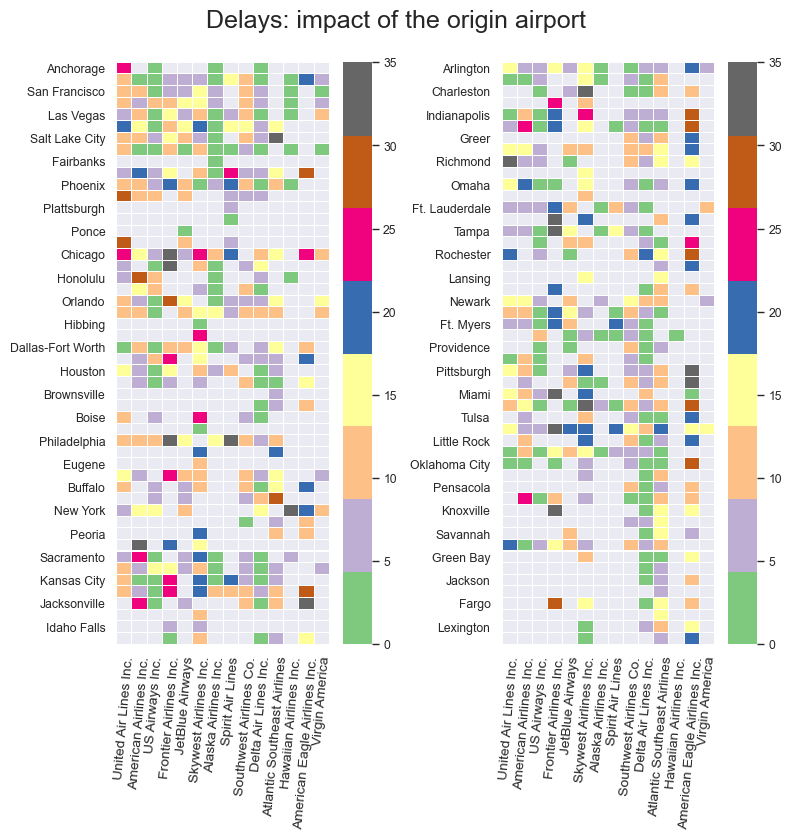

In [25]:
sns.set(context="paper")
fig = plt.figure(1, figsize=(8,8))

ax = fig.add_subplot(1,2,1)
subset = airport_mean_delays.iloc[:50,:].rename(columns = abbr_companies)
subset = subset.rename(index = identify_airport)
mask = subset.isnull()
sns.heatmap(subset, linewidths=0.01, cmap="Accent", mask=mask, vmin = 0, vmax = 35)
plt.setp(ax.get_xticklabels(), fontsize=10, rotation = 85) ;
ax.yaxis.label.set_visible(False)

ax = fig.add_subplot(1,2,2)    
subset = airport_mean_delays.iloc[50:100,:].rename(columns = abbr_companies)
subset = subset.rename(index = identify_airport)
fig.text(0.5, 1.02, "Delays: impact of the origin airport", ha='center', fontsize = 18)
mask = subset.isnull()
sns.heatmap(subset, linewidths=0.01, cmap="Accent", mask=mask, vmin = 0, vmax = 35)
plt.setp(ax.get_xticklabels(), fontsize=10, rotation = 85) ;
ax.yaxis.label.set_visible(False)

plt.tight_layout()

___
### 4.3 Các chuyến bay có độ trễ bất thường  ?

- Trong phần trước, chúng ta đã thấy rằng có sự khác nhau về sự chậm trễ khi xem xét các hãng hàng không khác nhau và các sân bay xuất phát khác nhau. Bây giờ ta sẽ thêm một mức độ chi tiết bằng cách không chỉ tập trung vào các sân bay ban đầu mà còn vào các chuyến bay: Nơi bắt đầu →→Nơi Đến. Mục tiêu ở đây là để xem liệu một số chuyến bay có bị trì hoãn một cách có hệ thống hay không hoặc ngược lại, có những chuyến bay luôn đúng giờ.
Sau đây, tôi xem xét trường hợp của một hãng hàng không. Ta liệt kê tất cả các chuyến bay A →
→
   B được thực hiện bởi công ty này và đối với mỗi trong số chúng, ta tạo danh sách độ trễ đã được record:

In [26]:
#_________________________________________________________________
# Ta chọn một công ti và tạo dataframe con của nó
carrier = 'AA'
df1 = df[df['AIRLINE']==carrier][['ORIGIN_AIRPORT','DESTINATION_AIRPORT','DEPARTURE_DELAY']]
#___________________________________________________________
# thu thập các tuyến bay và liệt kê  độ trễ cho mỗi tuyến
trajet = dict()
for ind, col in df1.iterrows():
    if pd.isnull(col['DEPARTURE_DELAY']): continue
    route = str(col['ORIGIN_AIRPORT'])+'-'+str(col['DESTINATION_AIRPORT'])
    if route in trajet.keys():
        trajet[route].append(col['DEPARTURE_DELAY'])
    else:
        trajet[route] = [col['DEPARTURE_DELAY']]
#____________________________________________________________________        
# chuyển dic trong danh sách để sắp xếp các tuyến đường theo sân bay đi
liste_trip = []
for key, value in trajet.items():
    liste_trip.append([key, value])
liste_trip.sort()

- Sau đó, ta tính toán độ trễ trung bình trên các tuyến bay khác nhau A →
→
   B, cũng như độ lệch chuẩn và sau khi hoàn tất, tạo một biểu diễn (cho một mẫu các chuyến bay):


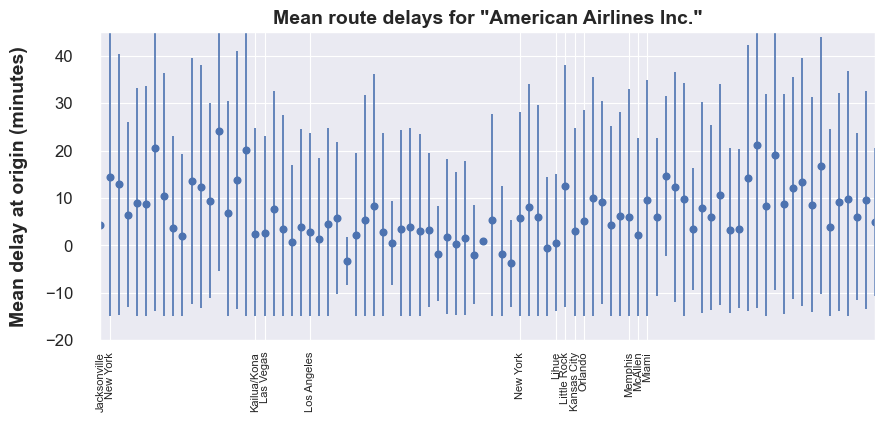

In [27]:
mean_val = [] ; std_val = [] ; x_label = []

i = 0
for route, liste_late in liste_trip:
    #_____________________________________________
    # I set the labels as the airport from origin
    index = route.split('-')[0]
    x_label.append(identify_airport[index])
    #______________________________________________________________________________
    # I put a threshold on delays to prevent that high values take too much weight
    trip2 = [min(90, s) for s in liste_late]
    #________________________________________
    # I compute mean and standard deviations
    mean_val.append(scipy.mean(trip2))
    std_val.append(scipy.std(trip2))
    i += 1
#________________
# Plot the graph
fig, ax = plt.subplots(figsize=(10,4))
std_min = [ min(15 + mean_val[i], s) for i,s in enumerate(std_val)] 
ax.errorbar(list(range(i)), mean_val, yerr = [std_min, std_val], fmt='o') 
ax.set_title('Mean route delays for "{}"'.format(abbr_companies[carrier]),
             fontsize=14, weight = 'bold')
plt.ylabel('Mean delay at origin (minutes)', fontsize=14, weight = 'bold', labelpad=12)
#___________________________________________________
# I define the x,y range and positions of the ticks
imin, imax = 145, 230
plt.xlim(imin, imax) ; plt.ylim(-20, 45)
liste_ticks = [imin]
for j in range(imin+1,imax):
    if x_label[j] == x_label[j-1]: continue
    liste_ticks.append(j)
#_____________________________
# and set the tick parameters  
ax.set_xticks(liste_ticks)
ax.set_xticklabels([x_label[int(x)] for x in ax.get_xticks()], rotation = 90, fontsize = 8)
plt.setp(ax.get_yticklabels(), fontsize=12, rotation = 0)
ax.tick_params(axis='y', which='major', pad=15)

plt.show()

- Con số này cho biết mức độ chậm trễ trung bình của American Airlines, theo thành phố xuất phát và điểm đến (lưu ý rằng trên trục abscissa, chỉ có điểm xuất phát được chỉ ra để rõ ràng). Các thanh được liên kết với các đường dẫn khác nhau tương ứng với độ lệch chuẩn. Trong ví dụ này, có thể thấy rằng đối với một sân bay xuất phát nhất định, độ trễ sẽ dao động tùy thuộc vào điểm đến. Ví dụ, chúng ta thấy rằng ở đây các biến thể lớn nhất thu được cho New York hoặc Miami, nơi mà độ trễ trung bình ban đầu thay đổi từ 0 đến ∼∼20 phút.
___
## 4. Sự thay đổi theo thời gian của độ trễ

- Trong phần này, ta xem xét cách thức mà độ trễ thay đổi theo thời gian. Xem xét trường hợp của một hãng hàng không và sân bay cụ thể, sự chậm trễ có thể dễ dàng được biểu thị theo ngày và giờ (_aside_: trước khi làm điều này, ta xác định một lớp mà ta sẽ sử dụng nhiều để tạo biểu đồ):

In [28]:
class Figure_style():
    #_________________________________________________________________
    def __init__(self, size_x = 11, size_y = 5, nrows = 1, ncols = 1):
        sns.set_style("white")
        sns.set_context("notebook", font_scale=1.2, rc={"lines.linewidth": 2.5})
        self.fig, axs = plt.subplots(nrows = nrows, ncols = ncols, figsize=(size_x,size_y,))
        #________________________________
        # convert self.axs to 2D array
        if nrows == 1 and ncols == 1:
            self.axs = np.reshape(axs, (1, -1))
        elif nrows == 1:
            self.axs = np.reshape(axs, (1, -1))
        elif ncols == 1:
            self.axs = np.reshape(axs, (-1, 1))
    #_____________________________
    def pos_update(self, ix, iy):
        self.ix, self.iy = ix, iy
    #_______________
    def style(self):
        self.axs[self.ix, self.iy].spines['right'].set_visible(False)
        self.axs[self.ix, self.iy].spines['top'].set_visible(False)
        self.axs[self.ix, self.iy].yaxis.grid(color='lightgray', linestyle=':')
        self.axs[self.ix, self.iy].xaxis.grid(color='lightgray', linestyle=':')
        self.axs[self.ix, self.iy].tick_params(axis='both', which='major',
                                               labelsize=10, size = 5)
    #________________________________________
    def draw_legend(self, location='upper right'):
        legend = self.axs[self.ix, self.iy].legend(loc = location, shadow=True,
                                        facecolor = 'g', frameon = True)
        legend.get_frame().set_facecolor('whitesmoke')
    #_________________________________________________________________________________
    def cust_plot(self, x, y, color='b', linestyle='-', linewidth=1, marker=None, label=''):
        if marker:
            markerfacecolor, marker, markersize = marker[:]
            self.axs[self.ix, self.iy].plot(x, y, color = color, linestyle = linestyle,
                                linewidth = linewidth, marker = marker, label = label,
                                markerfacecolor = markerfacecolor, markersize = markersize)
        else:
            self.axs[self.ix, self.iy].plot(x, y, color = color, linestyle = linestyle,
                                        linewidth = linewidth, label=label)
        self.fig.autofmt_xdate()
    #________________________________________________________________________
    def cust_plot_date(self, x, y, color='lightblue', linestyle='-',
                       linewidth=1, markeredge=False, label=''):
        markeredgewidth = 1 if markeredge else 0
        self.axs[self.ix, self.iy].plot_date(x, y, color='lightblue', markeredgecolor='grey',
                                  markeredgewidth = markeredgewidth, label=label)
    #________________________________________________________________________
    def cust_scatter(self, x, y, color = 'lightblue', markeredge = False, label=''):
        markeredgewidth = 1 if markeredge else 0
        self.axs[self.ix, self.iy].scatter(x, y, color=color,  edgecolor='grey',
                                  linewidths = markeredgewidth, label=label)    
    #___________________________________________
    def set_xlabel(self, label, fontsize = 14):
        self.axs[self.ix, self.iy].set_xlabel(label, fontsize = fontsize)
    #___________________________________________
    def set_ylabel(self, label, fontsize = 14):
        self.axs[self.ix, self.iy].set_ylabel(label, fontsize = fontsize)
    #____________________________________
    def set_xlim(self, lim_inf, lim_sup):
        self.axs[self.ix, self.iy].set_xlim([lim_inf, lim_sup])
    #____________________________________
    def set_ylim(self, lim_inf, lim_sup):
        self.axs[self.ix, self.iy].set_ylim([lim_inf, lim_sup])           

In [29]:
carrier = 'WN'
id_airport = 4
liste_origin_airport = df[df['AIRLINE'] == carrier]['ORIGIN_AIRPORT'].unique()
df2 = df[(df['AIRLINE'] == carrier) & (df['ARRIVAL_DELAY'] > 0)
         & (df['ORIGIN_AIRPORT'] == liste_origin_airport[id_airport])]
df2.sort_values('SCHEDULED_DEPARTURE', inplace = True)

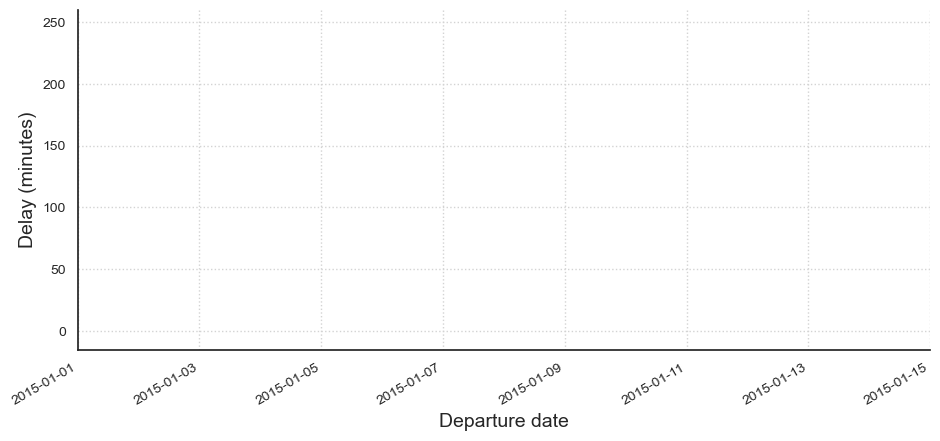

In [30]:
fig1 = Figure_style(11, 5, 1, 1)
fig1.pos_update(0, 0)
fig1.cust_plot(df2['SCHEDULED_DEPARTURE'], df2['DEPARTURE_DELAY'], linestyle='-')
fig1.style() 
fig1.set_ylabel('Delay (minutes)', fontsize = 14)
fig1.set_xlabel('Departure date', fontsize = 14)
date_1 = datetime.datetime(2015,1,1)
date_2 = datetime.datetime(2015,1,15)
fig1.set_xlim(date_1, date_2)
fig1.set_ylim(-15, 260)


- Hình này cho thấy sự tồn tại của các chu kỳ, cả về tần số của sự chậm trễ cũng như độ lớn của chúng. Trên thực tế, theo trực giác, có vẻ khá hợp lý khi quan sát các chu kỳ như vậy vì chúng sẽ là hệ quả của sự luân phiên giữa ngày và đêm và thực tế là hoạt động của sân bay sẽ giảm đáng kể (nếu không muốn nói là không tồn tại) vào ban đêm. Điều này cho thấy rằng một biến số quan trọng trong mô hình hóa độ trễ sẽ là thời gian cất cánh. Để kiểm tra giả thuyết này, tôi xem xét hành vi của độ trễ trung bình như một hàm của thời gian khởi hành, tổng hợp dữ liệu của tháng hiện tại:

In [31]:
#_______________________________
def func2(x, a, b, c):
    return a * x**2 +  b*x + c
#_______________________________
df2['hours_depart'] =  df2['SCHEDULED_DEPARTURE'].apply(lambda x:x.time())
test2 = df2['DEPARTURE_DELAY'].groupby(df2['hours_depart']).apply(get_stats).unstack()
fct = lambda x:x.hour*3600+x.minute*60+x.second
x_val = np.array([fct(s) for s in test2.index]) 
y_val = test2['mean']
popt, pcov = curve_fit(func2, x_val, y_val, p0 = [1, 2, 3])
test2['fit'] = pd.Series(func2(x_val, *popt), index = test2.index)

trực quan có được:

ConversionError: Failed to convert value(s) to axis units: array([datetime.time(6, 50), datetime.time(8, 45), datetime.time(9, 55),
       ..., datetime.time(19, 50), datetime.time(19, 50),
       datetime.time(19, 50)], dtype=object)

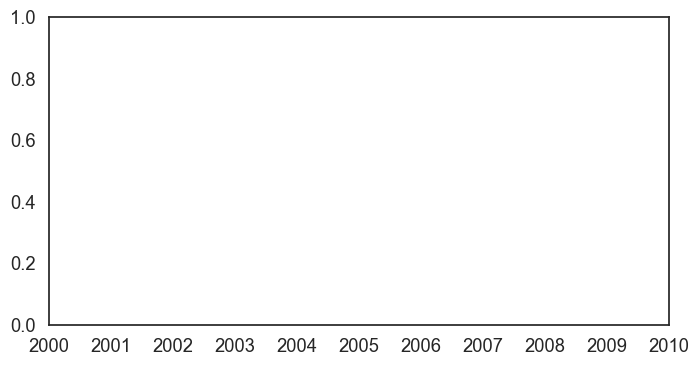

In [32]:
fig1 = Figure_style(8, 4, 1, 1)
fig1.pos_update(0, 0)
fig1.cust_plot_date(df2['hours_depart'], df2['DEPARTURE_DELAY'],
                    markeredge=False, label='initial data points')
fig1.cust_plot(test2.index, test2['mean'], linestyle='--', linewidth=2, label='mean')
fig1.cust_plot(test2.index, test2['fit'], color='r', linestyle='-', linewidth=3, label='fit')
fig1.style() ; fig1.draw_legend('upper left')
fig1.set_ylabel('Delay (minutes)', fontsize = 14)
fig1.set_xlabel('Departure time', fontsize = 14)
fig1.set_ylim(-15, 210)


- Ở đây, chúng ta có thể thấy rằng độ trễ trung bình có xu hướng tăng lên theo thời gian khởi hành trong ngày: chuyến bay khởi hành đúng giờ vào buổi sáng và thời gian trễ tăng gần như đơn điệu lên đến 30 phút vào cuối ngày. Trên thực tế, hành vi này khá chung chung và nhìn vào các sân bay hoặc công ty khác, chúng ta sẽ tìm thấy xu hướng tương tự.

___
## 6. Predicting flight delays 

- Các phần trước xử lý việc khám phá tập dữ liệu. Ở đây, ta bắt đầu với việc mô hình hóa độ trễ chuyến bay. Trong phần này, mục tiêu là tạo ra một mô hình sử dụng thời hạn 3 tuần để dự đoán sự chậm trễ của tuần tiếp theo. Do đó, chúng ta quyết định sẽ làm việc trên dữ liệu của tháng 1 với mục đích dự đoán độ trễ của ngày 23 đến ngày 31

In [33]:
df_train = df[df['SCHEDULED_DEPARTURE'].apply(lambda x:x.date()) < datetime.date(2019, 1, 23)]
df_test  = df[df['SCHEDULED_DEPARTURE'].apply(lambda x:x.date()) > datetime.date(2019, 1, 23)]
df = df_train

___
### 5.1 Model nº1: one airline, one airport


#### 5.1.1 Pitfalls <br>


**a) Unsufficient statistics**


Trước hết, ta xem xét các chuyến bay của * American Airlines * và thực hiện một cuộc điều tra số lượng các chuyến bay đã rời khỏi mỗi sân bay:

In [34]:
carrier = 'AA'
check_airports = df[(df['AIRLINE'] == carrier)]['DEPARTURE_DELAY'].groupby(
                         df['ORIGIN_AIRPORT']).apply(get_stats).unstack()
check_airports.sort_values('count', ascending = False, inplace = True)
check_airports[-5:]

,min,max,count,mean
ORIGIN_AIRPORT,,,,
JAC,-19.0,47.0,25.0,-3.640000
GUC,-24.0,199.0,22.0,13.227273
SDF,-8.0,55.0,19.0,8.421053
LIT,-5.0,74.0,9.0,12.555556
MTJ,-2.0,51.0,3.0,26.000000


- Nhìn vào danh sách này, chúng ta có thể thấy rằng những sân bay ít được ghé thăm hơn, chỉ có một vài chuyến bay trong một tháng. Vì vậy, trong trường hợp kém thuận lợi nhất, không thể thực hiện một hồi quy.

**b) Extreme delays**

- Một lỗi cần tránh là độ trễ "bất ngờ": cần đặc biệt chú ý đến các độ trễ quá lớn. Thật vậy, trong quá trình thăm dò, ta thấy rằng thỉnh thoảng có thể ghi nhận được sự chậm trễ vài giờ (thậm chí hàng chục giờ). Tuy nhiên, loại chậm trễ này là rất nhỏ (một vài%) và nguyên nhân của những sự chậm trễ này có thể liên quan đến các sự kiện không thể đoán trước (thời tiết, sự cố, tai nạn, ...). Mặt khác, tính đến sự chậm trễ kiểu này có thể sẽ dẫn đến sai lệch trong phân tích. Hơn nữa, trọng số của các giá trị lớn sẽ rất đáng kể nếu chúng ta có một thống kê nhỏ.

Để minh họa điều này, trước tiên ta định nghĩa một hàm tính toán độ trễ chuyến bay trung bình cho mỗi hãng hàng không và mỗi sân bay:

In [39]:
def get_flight_delays(df, carrier, id_airport, extrem_values = False):
    df2 = df[(df['AIRLINE'] == carrier) & (df['ORIGIN_AIRPORT'] == id_airport)]
    #_______________________________________
    # xoá đi những giá trị qúa lớn trước khi fitting
    if extrem_values:
        df2['DEPARTURE_DELAY'] = df2['DEPARTURE_DELAY'].apply(lambda x:x if x < 60 else np.nan)
        df2.dropna(how = 'any')
    #__________________________________
    # chuyển đổi: ngày + giờ - > giờ
    df2.sort_values('SCHEDULED_DEPARTURE', inplace = True)
    df2['hours_depart'] =  df2['SCHEDULED_DEPARTURE'].apply(lambda x:x.time())
    #___________________________________________________________________
    # phân nhóm các chuyến bay theo thời gian khởi hành và tính giá trị trung bình
    test2 = df2['DEPARTURE_DELAY'].groupby(df2['hours_depart']).apply(get_stats).unstack()
    test2.reset_index(inplace=True)
    #___________________________________
    
    fct = lambda x:x.hour*3600+x.minute*60+x.second
    test2.reset_index(inplace=True)
    test2['hours_depart_min'] = test2['hours_depart'].apply(fct)
    return test2

- và sau đó là một hàm thực hiện hồi quy tuyến tính trên các giá trị sau:

In [40]:
def linear_regression(test2):
    test = test2[['mean', 'hours_depart_min']].dropna(how='any', axis = 0)
    X = np.array(test['hours_depart_min'])
    Y = np.array(test['mean'])
    X = X.reshape(len(X),1)
    Y = Y.reshape(len(Y),1)
    regr = linear_model.LinearRegression()
    regr.fit(X, Y)
    result = regr.predict(X)
    return X, Y, result

- Sau đó ta xem xét hai kịch bản. Trong trường hợp đầu tiên, lấy tất cả các giá trị ban đầu và trong trường hợp thứ hai, ta loại bỏ tất cả các độ trễ lớn hơn 1 giờ trước khi tính độ trễ trung bình. Sự so sánh của hai trường hợp là khá rõ ràng:

In [41]:
id_airport = 'PHL'
df2 = df[(df['AIRLINE'] == carrier) & (df['ORIGIN_AIRPORT'] == id_airport)]
df2['hours_depart'] =  df2['SCHEDULED_DEPARTURE'].apply(lambda x:x.time())
df2['hours_depart'] = df2['hours_depart'].apply(lambda x:x.hour*3600+x.minute*60+x.second)
#___________________
# first case
test2 = get_flight_delays(df, carrier, id_airport, False)
X1, Y1, result2 = linear_regression(test2)
#___________________
# second case
test3 = get_flight_delays(df, carrier, id_airport, True)
X2, Y2, result3 = linear_regression(test3)

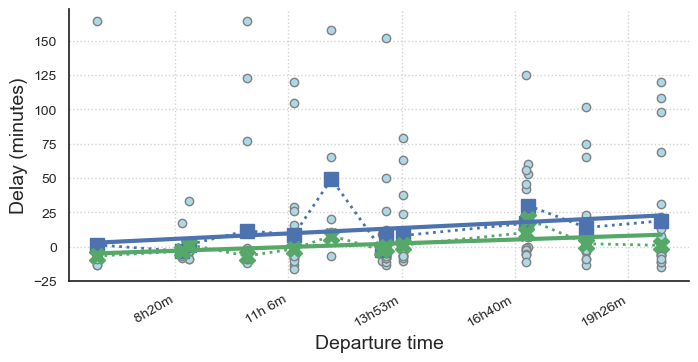

In [42]:
fig1 = Figure_style(8, 4, 1, 1)
fig1.pos_update(0, 0)
fig1.cust_scatter(df2['hours_depart'], df2['DEPARTURE_DELAY'], markeredge = True)
fig1.cust_plot(X1, Y1, color = 'b', linestyle = ':', linewidth = 2, marker = ('b','s', 10))
fig1.cust_plot(X2, Y2, color = 'g', linestyle = ':', linewidth = 2, marker = ('g','X', 12))
fig1.cust_plot(X1, result2, color = 'b', linewidth = 3)
fig1.cust_plot(X2, result3, color = 'g', linewidth = 3)
fig1.style()
fig1.set_ylabel('Delay (minutes)', fontsize = 14)
fig1.set_xlabel('Departure time', fontsize = 14)
#____________________________________
# convert and set the x ticks labels
fct_convert = lambda x: (int(x/3600) , int(divmod(x,3600)[1]/60))
fig1.axs[fig1.ix, fig1.iy].set_xticklabels(['{:2.0f}h{:2.0f}m'.format(*fct_convert(x))
                                            for x in fig1.axs[fig1.ix, fig1.iy].get_xticks()]);

- Trước hết, trong hình này, các điểm tương ứng với các chuyến bay riêng lẻ được thể hiện bằng các điểm màu xám. Giá trị trung bình của các điểm này cho độ trễ trung bình và giá trị trung bình của tập hợp các điểm ban đầu tương ứng với các ô vuông màu xanh lam. Bằng cách loại bỏ độ trễ cực độ (> 1h), người ta sẽ có được độ trễ trung bình được biểu thị bằng các dấu gạch chéo màu xanh lá cây. Do đó, trong trường hợp đầu tiên, sự phù hợp (đường cong màu xanh đặc) dẫn đến một dự đoán tương ứng với độ trễ trung bình là ∼
∼
   Lớn hơn 10 phút so với dự đoán thu được trong trường hợp thứ hai (đường cong màu xanh lá cây) và điều này, vào bất kỳ giờ nào trong ngày.
Kết luận, chúng ta thấy trong ví dụ này rằng cách chúng ta quản lý độ trễ cực độ sẽ có tác động quan trọng đến việc lập mô hình. Tuy nhiên, lưu ý rằng ví dụ hiện tại tương ứng với một trường hợp đã chọn trong đó tác động của sự chậm trễ cực độ được tăng lên bởi số lượng chuyến bay hạn chế. Có lẽ, tác động của sự chậm trễ như vậy sẽ ít rõ rệt hơn trong phần lớn các trường hợp.

___
#### 5.1.2 Polynomial degree: splitting the dataset


- Trên thực tế, thay vì thực hiện một hồi quy tuyến tính đơn giản, chúng ta có thể cải thiện mô hình để phù hợp với đa thức bậc 𝑁
 . Làm như vậy, cần phải xác định mức độ
  tối ưu để biểu diễn dữ liệu. Khi tăng bậc đa thức, điều quan trọng là **phải ngăn chặn overfiting** và chúng ta thực hiện việc này bằng cách tách tập dữ liệu trong các tập thử nghiệm và huấn luyện. Một vấn đề có thể nảy sinh với quy trình này là mô hình kết thúc bằng cách * gián tiếp học nội dung của tập kiểm tra và do đó bị sai lệch. Để tránh điều này, dữ liệu có thể được tách lại thành 3 bộ: train, test và validation. Một phương pháp thay thế cho kỹ thuật này, thường mạnh hơn, là phương pháp cross-validation. Phương pháp này bao gồm việc thực hiện tách dữ liệu đầu tiên trong các tập huấn luyện và tập test. Như mọi khi, việc học được thực hiện trên bộ đào tạo, nhưng để tránh học quá nhiều, nó được chia thành nhiều phần để sử dụng xen kẽ cho việc đào tạo và kiểm tra.
Lưu ý rằng nếu tập dữ liệu nhỏ, sự tách biệt trong các tập kiểm tra và huấn luyện có thể dẫn đến sai lệch trong ước lượng các tham số. Trong thực tế, phương pháp xác nhận chéo tránh được sự sai lệch như vậy. Trên thực tế, trong mô hình hiện tại, chúng ta sẽ gặp loại vấn đề này và trong phần tiếp theo, ta sẽ nêu rõ điều này. Ví dụ, chúng ta có thể xem xét một trường hợp cực đoan, sau khi tách, tập huấn luyện sẽ chỉ chứa giờ <<20h và tập kiểm tra sẽ có giờ>>
  8 giờ tối Sau đó, mô hình sẽ không thể tái tạo chính xác dữ liệu này, dữ liệu mà nó sẽ không thấy tương đương trong quá trình đào tạo. Phương pháp xác nhận chéo tránh được sự sai lệch này vì tất cả dữ liệu được sử dụng liên tiếp để điều khiển mô hình.
  
**a) Độ chệch được giới thiệu bởi việc tách tập dữ liệu**
Để kiểm tra tác động của việc phân tách dữ liệu đối với việc xác định mô hình, trước tiên tôi xác định lớp * fit_polynome *:

In [43]:
class fit_polynome:

    def __init__(self, data):
        self.data = data[['mean', 'hours_depart_min']].dropna(how='any', axis = 0)

    def split(self, method):        
        self.method = method        
        self.X = np.array(self.data['hours_depart_min'])
        self.Y = np.array(self.data['mean'])
        self.X = self.X.reshape(len(self.X),1)
        self.Y = self.Y.reshape(len(self.Y),1)

        if method == 'all':
            self.X_train = self.X
            self.Y_train = self.Y
            self.X_test  = self.X
            self.Y_test  = self.Y                        
        elif method == 'split':            
            self.X_train, self.X_test, self.Y_train, self.Y_test = \
                train_test_split(self.X, self.Y, test_size=0.3)
    
    def train(self, pol_order):
        self.poly = PolynomialFeatures(degree = pol_order)
        self.regr = linear_model.LinearRegression()
        self.X_ = self.poly.fit_transform(self.X_train)
        self.regr.fit(self.X_, self.Y_train)
    
    def predict(self, X):
        self.X_ = self.poly.fit_transform(X)
        self.result = self.regr.predict(self.X_)
    
    def calc_score(self):        
        X_ = self.poly.fit_transform(self.X_test)
        result = self.regr.predict(X_)
        self.score = metrics.mean_squared_error(result, self.Y_test)

- Lớp * fit_polynome * cho phép bạn thực hiện tất cả các thao tác liên quan đến việc fit  và save quả. Khi gọi phương thức split (), biến 'method' xác định cách dữ liệu ban đầu được phân tách:
- * method = 'all' *: tất cả dữ liệu đầu vào được sử dụng để huấn luyện và sau đó kiểm tra mô hình
- * method = 'split' *: chúng ta sử dụng phương thức * train_test_split () * của sklearn để xác định các bộ kiểm tra & đào tạo
Sau đó, các phương thức khác của lớp có các chức năng sau:
- ** train (n) **: điều khiển dữ liệu trên tập huấn luyện và tạo ra một đa thức bậc n
- ** dự đoán (X) **: tính toán các điểm Y được liên kết với đầu vào X và cho mô hình được điều khiển trước đó
- ** calc_score () **: tính toán điểm của mô hình liên quan đến dữ liệu bộ kiểm tra
Để minh họa sự sai lệch do việc lựa chọn tập hợp thử nghiệm đưa ra, ta tiến hành theo cách sau: thực hiện một số phân tách "train / test" của tập dữ liệu và đối với mỗi trường hợp, ta phù hợp với các đa thức có thứ tự ** n = 1, 2 và 3 *, bằng cách tính điểm số tương ứng của chúng. Sau đó,cho thấy rằng theo sự lựa chọn của phép tách, điểm tốt nhất có thể nhận được với bất kỳ giá trị nào của *n**. Trong thực tế, chỉ cần thực hiện hàng chục mô hình để có được kết quả này là đủ. Hơn nữa, sự sai lệch này được đưa ra bởi sự lựa chọn của "train / test" tách biệt và kết quả từ kích thước nhỏ của tập dữ liệu được mô hình hóa. Trên thực tế, tôi lấy ví dụ như trường hợp của hãng hàng không *American Airlines* (hãng hàng không lớn thứ hai) và sân bay có mã số 1129804, là sân bay có nhiều chuyến bay đăng ký nhất cho hãng đó. Đây là một trong những kịch bản ít thuận lợi nhất cho sự xuất hiện của loại thành kiến ​​này, tuy nhiên, vẫn có:

modèle nº1 , min. pour n = 1, score = 149.8
modèle nº2 , min. pour n = 2, score = 66.3
modèle nº3 , min. pour n = 1, score = 14.5
modèle nº4 , min. pour n = 2, score = 68.9
modèle nº5 , min. pour n = 3, score = 7.0


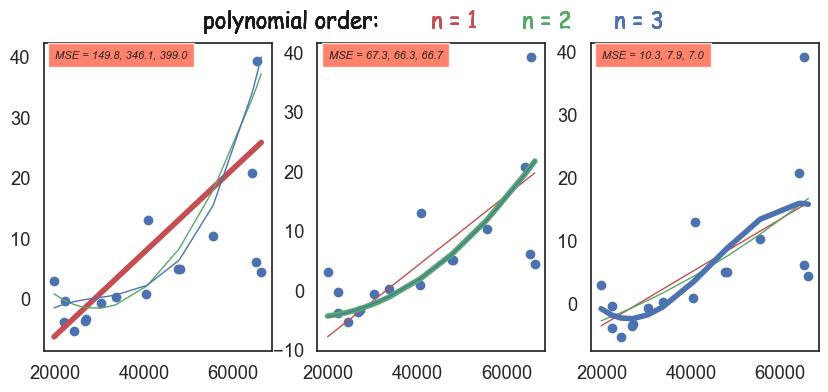

In [44]:
fig = plt.figure(1, figsize=(10,4))

ax = ['_' for _ in range(4)]
ax[1]=fig.add_subplot(131) 
ax[2]=fig.add_subplot(132) 
ax[3]=fig.add_subplot(133) 

id_airport = 'BNA'
test2 = get_flight_delays(df, carrier, id_airport, True)

result = ['_' for _ in range(4)]
score = [10000 for _ in range(4)]
found = [False for _ in range(4)]
fit = fit_polynome(test2)

color = '.rgbyc'

inc = 0
while True:
    inc += 1
    fit.split('split')
    for i in range(1,4):
        fit.train(pol_order = i)
        fit.predict(fit.X)
        result[i] = fit.result
        fit.calc_score()
        score[i]  = fit.score

    [ind_min] = [j for j,val in enumerate(score) if min(score) == val]
    print("modèle nº{:<2}, min. pour n = {}, score = {:.1f}".format(inc, ind_min,score[ind_min]))
    
    if not found[ind_min]:            
        for i in range(1,4):
            ax[ind_min].plot(fit.X, result[i], color[i], linewidth = 4 if i == ind_min else 1)
        ax[ind_min].scatter(fit.X, fit.Y)                
        ax[ind_min].text(0.05, 0.95, 'MSE = {:.1f}, {:.1f}, {:.1f}'.format(*score[1:4]),
                         style='italic', transform=ax[ind_min].transAxes, fontsize = 8,
                         bbox={'facecolor':'tomato', 'alpha':0.8, 'pad':5})                
        found[ind_min] = True

    shift = 0.5
    plt.text(-1+shift, 1.05, "polynomial order:", color = 'k',
                transform=ax[2].transAxes, fontsize = 16, family='fantasy')
    plt.text(0+shift, 1.05, "n = 1", color = 'r', 
                transform=ax[2].transAxes, fontsize = 16, family='fantasy')
    plt.text(0.4+shift, 1.05, "n = 2", color = 'g', 
                transform=ax[2].transAxes, fontsize = 16, family='fantasy')
    plt.text(0.8+shift, 1.05, "n = 3", color = 'b',
                transform=ax[2].transAxes, fontsize = 16, family='fantasy')
   
    if inc == 40 or all(found[1:4]): break

- Trong hình này, các bảng từ trái sang phải tương ứng với 3 phần phân tách dữ liệu trong tập huấn luyện và thử nghiệm, trong đó các mô hình tốt nhất thu được tương ứng với các đa thức bậc 1, 2 và 3. Trên mỗi bảng này, 3 phù hợp với các đa thức đã được đại diện và mô hình tốt nhất tương ứng với đường cong dày

**b) Lựa chọn bằng cách xác nhận chéo**
Một trong những ưu điểm của phương pháp xác nhận chéo là nó tránh được sự sai lệch vừa đặt ra khi chọn bậc của đa thức. Để sử dụng phương pháp này, tôi xác định một lớp mới mà tôi sẽ sử dụng sau này để thực hiện các khớp:

In [ ]:
class fit_polynome_cv:

    def __init__(self, data):
        self.data = data[['mean', 'hours_depart_min']].dropna(how='any', axis = 0)
        self.X = np.array(self.data['hours_depart_min'])
        self.Y = np.array(self.data['mean'])
        self.X = self.X.reshape(len(self.X),1)
        self.Y = self.Y.reshape(len(self.Y),1)

    def train(self, pol_order, nb_folds):
        self.poly = PolynomialFeatures(degree = pol_order)
        self.regr = linear_model.LinearRegression()
        self.X_ = self.poly.fit_transform(self.X)
        self.result = cross_val_predict(self.regr, self.X_, self.Y, cv = nb_folds)
    
    def calc_score(self, pol_order, nb_folds):
        self.poly = PolynomialFeatures(degree = pol_order)
        self.regr = linear_model.LinearRegression()
        self.X_ = self.poly.fit_transform(self.X)
        self.score = np.mean(cross_val_score(self.regr, self.X_, self.Y,
                                             cv = nb_folds, scoring = 'mean_squared_error'))


- Lớp này có hai phương thức:
** train (n, nb_folds) **: các tập huấn luyện 'nb_folds' được xác định từ tập dữ liệu ban đầu và điều khiển một đa thức bậc 'n' trên mỗi tập này. Phương pháp này trả về kết quả là các dự đoán Y thu được cho các bộ thử nghiệm khác nhau.
** calc_score (n, nb_folds) *: thực hiện quy trình tương tự như phương thức * train ** ngoại trừ phương thức này tính điểm phù hợp chứ không phải các giá trị dự đoán trên các dữ liệu thử nghiệm khác nhau.
Theo mặc định, phương thức 'K-fold' được sử dụng bởi các phương thức sklearn * cross_val_posystem () * và * cross_val_score () *. Các phương pháp này có tính xác định trong việc lựa chọn K nếp gấp, điều này ngụ ý rằng đối với một giá trị K cố định, kết quả thu được khi sử dụng các phương pháp này sẽ luôn giống nhau. Như đã thấy trong ví dụ trước, đây không phải là trường hợp khi sử dụng phương thức train_test_split (). Do đó, nếu chúng ta lấy cùng một tập dữ liệu như trong ví dụ trước, phương pháp xác nhận chéo sẽ giúp chúng ta có thể chọn mức độ đa thức tốt nhất:

In [ ]:
#id_airport = 1129804 
nb_folds = 10
print('Max possible number of folds: {} \n'.format(test2.shape[0]-1))
fit2 = fit_polynome_cv(test2)
for i in range(1, 8):
    fit2.calc_score(i, nb_folds)
    print('n={} -> MSE = {}'.format(i, round(abs(fit2.score),3)))



Chúng ta có thể thấy rằng sử dụng phương pháp này cho chúng ta rằng mô hình tốt nhất (tức là mô hình tổng quát tốt nhất) thu được với một đa thức bậc 2. Ở giai đoạn này của thủ tục, việc lựa chọn đa thức bậc a đã được xác nhận và bây giờ chúng ta có thể sử dụng tất cả dữ liệu để thực hiện phù hợp:

In [ ]:
fit = fit_polynome(test2)
fit.split('all')
fit.train(pol_order = 2)
fit.predict(fit.X)


- Do đó, trong hình dưới đây, phần ghép của đa thức K = 50 tương ứng với phép tính xác nhận chéo dẫn đến đường cong màu đỏ. Sự phù hợp đa thức tương ứng với mô hình cuối cùng tương ứng với đường cong màu xanh lam.

In [ ]:
fit2.train(pol_order = 2, nb_folds = nb_folds)

In [ ]:
fig1 = Figure_style(8, 4, 1, 1) ; fig1.pos_update(0, 0)
fig1.cust_scatter(fit2.X, fit2.Y, markeredge = True, label = 'initial data points')
fig1.cust_plot(fit.X,fit2.result,color=u'#1f77b4',linestyle='--',linewidth=2,label='CV output')
fig1.cust_plot(fit.X,fit.result,color=u'#ff7f0e',linewidth = 3,label='final fit')
fig1.style(); fig1.draw_legend('upper left')
fig1.set_ylabel('Delay (minutes)') ; fig1.set_xlabel('Departure time')
#____________________________________
# convert and set the x ticks labels
fct_convert = lambda x: (int(x/3600) , int(divmod(x,3600)[1]/60))
fig1.axs[fig1.ix, fig1.iy].set_xticklabels(['{:2.0f}h{:2.0f}m'.format(*fct_convert(x))
                                            for x in fig1.axs[fig1.ix, fig1.iy].get_xticks()]);

In [ ]:
score = metrics.mean_squared_error(fit.result, fit2.Y)
score

#### 5.1.3 Model test: prediction of end-January delays

Ở giai đoạn này, mô hình được điều khiển được thử nghiệm trên tập huấn luyện bao gồm dữ liệu của 3 tuần đầu tiên của tháng Giêng. Bây giờ chúng ta xem xét so sánh các dự đoán và quan sát cho tuần thứ 4 của tháng 1:

In [ ]:
test_data = get_flight_delays(df_test, carrier, id_airport, True)
test_data = test_data[['mean', 'hours_depart_min']].dropna(how='any', axis = 0)
X_test = np.array(test_data['hours_depart_min'])
Y_test = np.array(test_data['mean'])
X_test = X_test.reshape(len(X_test),1)
Y_test = Y_test.reshape(len(Y_test),1)
fit.predict(X_test)

and the MSE score of the model is:

In [ ]:
score = metrics.mean_squared_error(fit.result, Y_test)
score


Để biết được ý nghĩa của một giá trị như vậy đối với MSE, chúng ta có thể giả định một lỗi không đổi trên mỗi điểm của tập dữ liệu. Trong trường hợp đó, tại mỗi thời điểm
i
  , chúng ta có:
  
\begin{eqnarray}
y_i - f(x_i) = cste = \sqrt{MSE}
\end{eqnarray}




- do đó tạo ra sự khác biệt về số phút giữa độ trễ dự đoán và độ trễ thực tế. Trong trường hợp này, sự khác biệt giữa mô hình và các quan sát thường là:

In [ ]:
'Ecart = {:.2f} min'.format(np.sqrt(score))

___
### 5.2 Model nº2: One airline, all airports

Trong phần trước, mô hình chỉ xem xét một sân bay. Quy trình này có khả năng không hiệu quả vì có khả năng một số quan sát có thể được ngoại suy từ một cổng tới cổng khác. Do đó, có thể có lợi khi thực hiện một sự phù hợp duy nhất, điều này sẽ tính đến tất cả các sân bay. Đặc biệt, điều này sẽ cho phép dự đoán sự chậm trễ của các sân bay có số lượng dữ liệu thấp với độ chính xác cao hơn.

In [ ]:
def get_merged_delays(df, carrier):
    liste_airports = df[df['AIRLINE'] == carrier]['ORIGIN_AIRPORT'].unique()
    i = 0
    liste_columns = ['AIRPORT_ID', 'hours_depart_min', 'mean']
    for id_airport in liste_airports:
        test2 = get_flight_delays(df, carrier, id_airport, True)
        test2.loc[:, 'AIRPORT_ID'] = id_airport
        test2 = test2[liste_columns]
        test2.dropna(how = 'any', inplace = True)
        if i == 0:
            merged_df = test2.copy()
        else:
            merged_df = pd.concat([merged_df, test2], ignore_index = True)
        i += 1    
    return merged_df

In [ ]:
carrier = 'AA'
merged_df = get_merged_delays(df, carrier)
merged_df.shape


Trong khung dữ liệu *merge_df*, các sân bay được tham chiếu bởi một số nhận dạng được cung cấp trong biến **ORIGIN_AIRPORT**.
Các nhãn tương ứng không thể được sử dụng trực tiếp cho phù hợp và do đó ta sử dụng phương pháp *one-hot-encoding*:

In [ ]:
label_encoder = LabelEncoder()
integer_encoded = label_encoder.fit_transform(merged_df['AIRPORT_ID'])
#__________________________________________________________
# correspondance between the codes and tags of the airports
zipped = zip(integer_encoded, merged_df['AIRPORT_ID'])
label_airports = list(set(list(zipped)))
label_airports.sort(key = lambda x:x[0])
label_airports[:5]


Ở trên,ta đã chỉ định một nhãn cho mỗi sân bay. Sự tương ứng giữa nhãn và số nhận dạng ban đầu đã được lưu trong danh sách *label_airport*. Bây giờ tôi tiếp tục với "Một mã hóa phổ biến" bằng cách tạo một ma trận trong đó thay vì biến **ORIGIN_AIRPORT** có chứa nhãn $M$, chúng ta xây dựng một ma trận với các cột $M$, chứa 0 và 1 tùy thuộc vào sự tương ứng với các sân bay cụ thể:

In [ ]:
onehot_encoder = OneHotEncoder(sparse=False)
integer_encoded = integer_encoded.reshape(len(integer_encoded), 1)
onehot_encoded = onehot_encoder.fit_transform(integer_encoded)
b = np.array(merged_df['hours_depart_min'])
b = b.reshape(len(b),1)
X = np.hstack((onehot_encoded, b))
Y = np.array(merged_df['mean'])
Y = Y.reshape(len(Y), 1)
print(X.shape, Y.shape)

___
#### 5.2.1 Linear regression

Các ma trận X và Y do đó được tạo ra có thể được sử dụng để thực hiện một hồi quy tuyến tính:

In [ ]:
lm = linear_model.LinearRegression()
model = lm.fit(X,Y)
predictions = lm.predict(X)
print("MSE =", metrics.mean_squared_error(predictions, Y))

Ở đây, ta đã tính điểm MSE của sự phù hợp. Trên thực tế, chúng ta có thể có cảm giác về chất lượng của sự phù hợp bằng cách xem xét số lượng dự đoán trong đó chênh lệch với giá trị thực lớn hơn 15 phút:

In [ ]:
icount = 0
for i, val in enumerate(Y):
    if abs(val-predictions[i]) > 15: icount += 1
'{:.2f}%'.format(icount / len(predictions) * 100)

Trong thực tế, mô hình này có xu hướng đánh giá thấp các độ trễ lớn, có thể thấy trong hình sau:

In [ ]:
tips = pd.DataFrame()
tips["prediction"] = pd.Series([float(s) for s in predictions]) 
tips["original_data"] = pd.Series([float(s) for s in Y]) 
sns.jointplot(x="original_data", y="prediction", data=tips, size = 6, ratio = 7,
              joint_kws={'line_kws':{'color':'limegreen'}}, kind='reg')
plt.xlabel('Mean delays (min)', fontsize = 15)
plt.ylabel('Predictions (min)', fontsize = 15)
plt.plot(list(range(-10,25)), list(range(-10,25)), linestyle = ':', color = 'r')
sns.plt.show()

___
#### 5.2.2 Polynomial regression

Bây giờ ta sẽ mở rộng fit trước đó bằng cách sử dụng một đa thức thay vì một hàm tuyến tính:

In [ ]:
poly = PolynomialFeatures(degree = 2)
regr = linear_model.LinearRegression()
X_ = poly.fit_transform(X)
regr.fit(X_, Y)

In [ ]:
result = regr.predict(X_)
print("MSE =", metrics.mean_squared_error(result, Y))

Chúng ta có thể thấy rằng sự phù hợp đa thức cải thiện một chút điểm MSE. Trên thực tế, tỷ lệ phần trăm giá trị trong đó chênh lệch giữa dự đoán và độ trễ thực lớn hơn 15 phút là:

In [ ]:
icount = 0
for i, val in enumerate(Y):
    if abs(val-result[i]) > 15: icount += 1
'{:.2f}%'.format(icount / len(result) * 100)

Và như trước đây, có thể thấy rằng mô hình có xu hướng tệ hơn trong trường hợp có độ trễ lớn:

In [ ]:
tips = pd.DataFrame()
tips["prediction"] = pd.Series([float(s) for s in result]) 
tips["original_data"] = pd.Series([float(s) for s in Y]) 
sns.jointplot(x="original_data", y="prediction", data=tips, size = 6, ratio = 7,
              joint_kws={'line_kws':{'color':'limegreen'}}, kind='reg')
plt.xlabel('Mean delays (min)', fontsize = 15)
plt.ylabel('Predictions (min)', fontsize = 15)
plt.plot(list(range(-10,25)), list(range(-10,25)), linestyle = ':', color = 'r')
sns.plt.show()

___
#### 5.2.3 Setting the free parameters

Trên đây, hai mô hình đã được fit và test trên bộ huấn luyện. Trong thực tế, như đã đề cập ở trên, khi tiến hành theo cách đó và các tham số tự do của mô hình sẽ bị sai lệch. Do đó, mô hình sẽ không cho phép tổng quát hóa tốt. Vì vậy, ta sẽ chia nhỏ dữ liệu để đào tạo và sau đó kiểm tra mô hình. Mục đích sẽ là xác định bậc đa thức cho phép tổng quát hóa tốt nhất các dự đoán:

In [ ]:
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.3)


Như trước đây, ta fit với mô hình trên tập huấn luyện:

In [ ]:
X_train.shape

In [ ]:
poly = PolynomialFeatures(degree = 2)
regr = linear_model.LinearRegression()
X_ = poly.fit_transform(X_train)
regr.fit(X_, Y_train)
result = regr.predict(X_)
score = metrics.mean_squared_error(result, Y_train)
print("Mean squared error = ", score)

Bây giờ, bằng cách thử nghiệm trên bộ thử nghiệm, chúng ta nhận được:

In [ ]:
X_ = poly.fit_transform(X_test)
result = regr.predict(X_)
score = metrics.mean_squared_error(result, Y_test)
print("Mean squared error = ", score)

Ở đây, chúng ta thấy rằng **fit đặc biệt tệ với MSE> 500 ** (giá trị chính xác phụ thuộc vào quá trình chạy và phân chia tập dữ liệu), có nghĩa là fit hoạt động kém khi phân chia thành dữ liệu khác. Bây giờ chúng ta hãy xem xét chi tiết lý do tại sao chúng ta có điểm số tồi tệ như vậy. Dưới đây, ta kiểm tra tất cả các số hạng của phép tính MSE và xác định các số hạng lớn nhất:

In [ ]:
somme = 0
for valeurs in zip(result, Y_test):
    ajout = (float(valeurs[0]) - float(valeurs[1]))**2
    somme += ajout
    if ajout > 10**4:
        print("{:<.1f} {:<.1f} {:<.1f}".format(ajout, float(valeurs[0]), float(valeurs[1])))

Chúng ta thấy rằng một số dự đoán cho thấy sai số rất lớn. Trong thực tế, điều này có thể được giải thích là do trong quá trình phân tách trong tập huấn luyện và tập kiểm tra, ** dữ liệu không tương đương trong tập huấn luyện đã được đưa vào dữ liệu thử nghiệm **. Do đó, khi tính toán dự đoán, mô hình phải ** thực hiện một phép ngoại suy **. Nếu hệ số của sự phù hợp lớn (thường xảy ra khi overfitting), các giá trị ngoại suy sẽ hiển thị các giá trị quan trọng, như trong trường hợp hiện tại. Để kiểm soát hiện tượng này, chúng ta có thể sử dụng ** phương pháp chính quy hóa ** sẽ đưa ra một hình phạt cho các mô hình có hệ số là quan trọng nhất:

In [ ]:
from sklearn.linear_model import Ridge
ridgereg = Ridge(alpha=0.3,normalize=True)
poly = PolynomialFeatures(degree = 2)
X_ = poly.fit_transform(X_train)
ridgereg.fit(X_, Y_train)

Bây giờ, nếu chúng ta tính điểm liên quan đến các dự đoán được thực hiện bằng kỹ thuật regularization, chúng ta có:

In [ ]:
X_ = poly.fit_transform(X_test)
result = ridgereg.predict(X_)
score = metrics.mean_squared_error(result, Y_test)
print("Mean squared error = ", score)

Chúng ta có thể thấy rằng chúng tôi đạt được một số điểm hợp lý. Do đó, với quy trình hiện tại, để xác định mô hình tốt nhất, chúng ta có hai tham số trống để điều chỉnh: bậc đa thức và hệ số $\alpha$ của *'Ridge Regression'*:

In [ ]:
score_min = 10000
for pol_order in range(1, 3):
    for alpha in range(0, 20, 2):
        ridgereg = Ridge(alpha = alpha/10, normalize=True)
        poly = PolynomialFeatures(degree = pol_order)
        regr = linear_model.LinearRegression()
        X_ = poly.fit_transform(X_train)
        ridgereg.fit(X_, Y_train)        
        X_ = poly.fit_transform(X_test)
        result = ridgereg.predict(X_)
        score = metrics.mean_squared_error(result, Y_test)        
        if score < score_min:
            score_min = score
            parameters = [alpha/10, pol_order]
        print("n={} alpha={} , MSE = {:<0.5}".format(pol_order, alpha, score))

Chúng ta hãy lưu ý rằng đối với mô hình này, các ước lượng thu được với hồi quy tuyến tính hoặc đa thức bậc 2 là khá gần nhau. Bây giờ ta sử dụng các tham số này để kiểm tra mẫu này trên bộ thử nghiệm:

In [ ]:
ridgereg = Ridge(alpha = parameters[0], normalize=True)
poly = PolynomialFeatures(degree = parameters[1])
X_ = poly.fit_transform(X)
ridgereg.fit(X_, Y)
result = ridgereg.predict(X_)
score = metrics.mean_squared_error(result, Y)        
print(score)

#### 6.2.4 Testing the model: delays of end-january


Ở giai đoạn này, các dự đoán của mô hình được kiểm tra dựa trên dữ liệu cuối tháng 1. Những dữ liệu này được trích xuất đầu tiên:

In [ ]:
carrier = 'AA'
merged_df_test = get_merged_delays(df_test, carrier)

sau đó tôi chuyển đổi chúng thành một định dạng phù hợp để thực hiện phù hợp. Ở giai đoạn này, tôi thực hiện mã hóa one-hot-coding theo cách thủ công bằng cách sử dụng lại nhãn đã được thiết lập trên dữ liệu đào tạo:

In [ ]:
label_conversion = dict()
for s in label_airports:
    label_conversion[s[1]] = s[0]

merged_df_test['AIRPORT_ID'].replace(label_conversion, inplace = True)

for index, label in label_airports:
    temp = merged_df_test['AIRPORT_ID'] == index
    temp = temp.apply(lambda x:1.0 if x else 0.0)
    if index == 0:
        matrix = np.array(temp)
    else:
        matrix = np.vstack((matrix, temp))
matrix = matrix.T

b = np.array(merged_df_test['hours_depart_min'])
b = b.reshape(len(b),1)
X_test = np.hstack((matrix, b))
Y_test = np.array(merged_df_test['mean'])
Y_test = Y_test.reshape(len(Y_test), 1)

Sau đó, ta có thể tạo các dự đoán

In [ ]:
X_ = poly.fit_transform(X_test)
result = ridgereg.predict(X_)
score = metrics.mean_squared_error(result, Y_test)
'MSE = {:.2f}'.format(score)


Như trước đây, giả sử rằng độ trễ độc lập với điểm, điểm MSE này tương đương với độ trễ trung bình là:

In [ ]:
'Ecart = {:.2f} min'.format(np.sqrt(score))



- Điểm MSE hiện tại được tính trên tất cả các sân bay do _American Airlines_ phục vụ, trong khi trước đây nó được tính trên dữ liệu của một sân bay. Mô hình hiện tại do đó tổng quát hơn. Hơn nữa, nếu xét theo mô hình trước đây, nhiều khả năng dự đoán sẽ kém đối với các sân bay có số liệu thống kê thấp.


____
## 6.3 Model nº3: Accounting for destinations



- Trong mô hình trước, ta đã nhóm các chuyến bay theo thời gian khởi hành. Do đó, các chuyến bay với các điểm đến khác nhau đã được nhóm lại ngay khi chúng khởi hành cùng lúc. Bây giờ ta tạo một mô hình tính cả thời gian khởi hành và thời gian đến:

In [ ]:
def create_df(df, carrier):
    df2 = df[df['AIRLINE'] == carrier][['SCHEDULED_DEPARTURE','SCHEDULED_ARRIVAL',
                                    'ORIGIN_AIRPORT','DESTINATION_AIRPORT','DEPARTURE_DELAY']]
    df2.dropna(how = 'any', inplace = True)
    df2['weekday'] = df2['SCHEDULED_DEPARTURE'].apply(lambda x:x.weekday())
    #____________________
    # delete delays > 1h
    df2['DEPARTURE_DELAY'] = df2['DEPARTURE_DELAY'].apply(lambda x:x if x < 60 else np.nan)
    df2.dropna(how = 'any', inplace = True)
    #_________________
    # formating times
    fct = lambda x:x.hour*3600+x.minute*60+x.second
    df2['hours_depart'] = df2['SCHEDULED_DEPARTURE'].apply(lambda x:x.time())
    df2['hours_depart'] = df2['hours_depart'].apply(fct)
    df2['hours_arrivee'] = df2['SCHEDULED_ARRIVAL'].apply(fct)
    df3 = df2.groupby(['hours_depart', 'hours_arrivee', 'ORIGIN_AIRPORT'],
                      as_index = False).mean()
    return df3

In [ ]:
df3 = create_df(df, carrier)    
df3[:5]

Do đó, việc tập hợp lại được thực hiện vào thời gian khởi hành và đến, và các sân bay xuất phát và điểm đến (cụ thể) đã được tính đến. Như trước đây, ta thực hiện mã hóa các sân bay:

In [ ]:
label_encoder = LabelEncoder()
integer_encoded = label_encoder.fit_transform(df3['ORIGIN_AIRPORT'])
#_________________________________________________________
zipped = zip(integer_encoded, df3['ORIGIN_AIRPORT'])
label_airports = list(set(list(zipped)))
label_airports.sort(key = lambda x:x[0])
#_________________________________________________
onehot_encoder = OneHotEncoder(sparse=False)
integer_encoded = integer_encoded.reshape(len(integer_encoded), 1)
onehot_encoded = onehot_encoder.fit_transform(integer_encoded)
#_________________________________________________
b = np.array(df3[['hours_depart', 'hours_arrivee']])
X = np.hstack((onehot_encoded, b))
Y = np.array(df3['DEPARTURE_DELAY'])
Y = Y.reshape(len(Y), 1)

___
#### 6.3.1 Choice of model parameters

Như trước đây, ta sẽ thực hiện một hồi quy với chính quy và ta sẽ phải xác định giá trị để thuộc tính cho tham số $\alpha$. Do đó, ta tách dữ liệu để đào tạo và sau đó kiểm tra mô hình để chọn giá trị tốt nhất cho $\alpha$:

In [ ]:
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.3)

In [ ]:
score_min = 10000
for pol_order in range(1, 3):
    for alpha in range(0, 20, 2):
        ridgereg = Ridge(alpha = alpha/10, normalize=True)
        poly = PolynomialFeatures(degree = pol_order)
        regr = linear_model.LinearRegression()
        X_ = poly.fit_transform(X_train)
        ridgereg.fit(X_, Y_train)
        
        X_ = poly.fit_transform(X_test)
        result = ridgereg.predict(X_)
        score = metrics.mean_squared_error(result, Y_test)
        
        if score < score_min:
            score_min = score
            parameters = [alpha, pol_order]

        print("n={} alpha={} , MSE = {:<0.5}".format(pol_order, alpha/10, score))

In [ ]:
ridgereg = Ridge(alpha = parameters[0], normalize=True)
poly = PolynomialFeatures(degree = parameters[1])
X_ = poly.fit_transform(X)
ridgereg.fit(X_, Y)
result = ridgereg.predict(X_)
score = metrics.mean_squared_error(result, Y)        
print(score)

#### 6.3.2 Test of the model: late January delays

Bây giờ ta kiểm tra chất lượng của các dự đoán trên dữ liệu của tuần cuối cùng của tháng 1. Đầu tiên ta trích xuất những dữ liệu này:

In [ ]:
df3 = create_df(df_test, carrier)    
df3[:5]

In [ ]:
label_conversion = dict()
for s in label_airports:
    label_conversion[s[1]] = s[0]

df3['ORIGIN_AIRPORT'].replace(label_conversion, inplace = True)

for index, label in label_airports:
    temp = df3['ORIGIN_AIRPORT'] == index
    temp = temp.apply(lambda x:1.0 if x else 0.0)
    if index == 0:
        matrix = np.array(temp)
    else:
        matrix = np.vstack((matrix, temp))
matrix = matrix.T

b = np.array(df3[['hours_depart', 'hours_arrivee']])
X_test = np.hstack((matrix, b))
Y_test = np.array(df3['DEPARTURE_DELAY'])
Y_test = Y_test.reshape(len(Y_test), 1)

In [ ]:
X_ = poly.fit_transform(X_test)
result = ridgereg.predict(X_)
score = metrics.mean_squared_error(result, Y_test)
print('MSE = {}'.format(round(score, 2)))

tương ứng với độ trễ trung bình là:

In [ ]:
'Ecart = {:.2f} min'.format(np.sqrt(score))

In [ ]:
icount = 0
for i, val in enumerate(Y_test):
    if abs(val-predictions[i]) > 15: icount += 1
print("ecarts > 15 minutes: {}%".format(round((icount / len(predictions))*100,3)))

In [ ]:
tips = pd.DataFrame()
tips["prediction"] = pd.Series([float(s) for s in predictions]) 
tips["original_data"] = pd.Series([float(s) for s in Y_test]) 
sns.jointplot(x="original_data", y="prediction", data=tips, size = 6, ratio = 7,
              joint_kws={'line_kws':{'color':'limegreen'}}, kind='reg')
plt.xlabel('Mean delays (min)', fontsize = 15)
plt.ylabel('Predictions (min)', fontsize = 15)
plt.plot(list(range(-10,25)), list(range(-10,25)), linestyle = ':', color = 'r')
sns.plt.show()